In [32]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import v2
from torch import nn
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

import scipy

import random

In [33]:
from google.colab import drive
drive.mount('/content/drive')

data_file = './drive/MyDrive/ml/train.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
data = pd.read_csv(data_file)
data.sample(5)
# pixel = 28*i + j

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
5317,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4511,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9283,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5472,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2873,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
im_rows = data.drop('label', axis=1)
MEAN = im_rows.stack().mean() #np.mean(data.drop('label', axis=1))
# print(im_rows.stack())
STD = im_rows.stack().std() #np.std(data.drop('label', axis=1))
f'{MEAN=}, {STD=}'

'MEAN=33.408911169825075, STD=78.67774095545718'

In [36]:
len(data.columns)

785

In [37]:
images_count = len(data['label'])
images_count

42000

In [38]:
data['label'].loc[3]

4

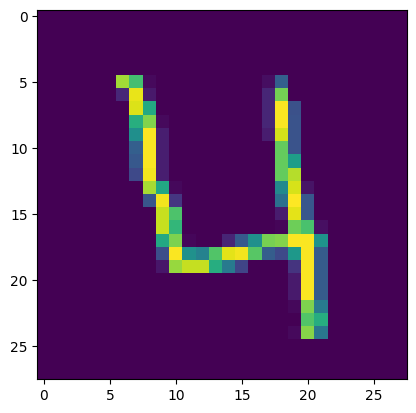

In [39]:
number = None
# for i in range(images_count):
row = data.loc[3]
row = row[1:]
# print(row.values)
# break
number = torch.tensor(row.values)
number = number.reshape(28,28)
plt.imshow(number)

In [40]:
class myCIFAR(Dataset):
    def __init__(self, df):
        # self.dataset = df
        self.im_rows = df.drop('label', axis=1)
        self.labels = df['label']
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, ind):
        label = self.labels.iloc[ind]
        label = F.one_hot(torch.tensor(label), num_classes=10)
        row = self.im_rows.iloc[ind].values
        image = torch.tensor(row).reshape(28,28)
        image = image.unsqueeze(0)
        return image, label

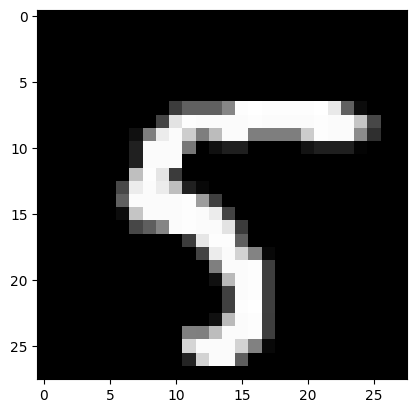

In [41]:
train_data = myCIFAR(data)
loader = DataLoader(train_data, batch_size=1, shuffle=True)
for im, label in loader:
    plt.imshow(im[0][0], cmap='gray')
    # print(im)
    break

In [42]:
transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=False),
    v2.Normalize(mean=[MEAN], std=[STD])
])

In [43]:
train_data = myCIFAR(data)
loader = DataLoader(train_data, batch_size=1, shuffle=True)
for im, label in tqdm(loader, total=len(loader)):
    im = transforms(im)

100%|██████████| 42000/42000 [00:27<00:00, 1521.39it/s]


In [49]:
class Recognizer(nn.Module):
    def __init__(self):
        super(Recognizer, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(5,5)),
            nn.ReLU())
        # self.avgpool1 = nn.AvgPool2d(kernel_size=3)
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(5,5)),
            nn.ReLU())
        # self.avgpool2 = nn.AvgPool2d(kernel_size=3, stride=(1,1))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2), stride=(1,1))

        self.d1 = nn.Dropout(p=0.25)

        self.conv3 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=(3,3)),
        nn.ReLU())
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(3,3)),
            nn.ReLU())

        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.d2 = nn.Dropout(p=0.5)

        self.fc1 = nn.Linear(3136, 256)#12800 #3136
        self.relu = nn.ReLU()

        self.d3 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(256, 10)
        self.softmax = nn.Softmax()
    def forward(self, x):
        x = self.conv2(self.conv1(x))
        x = self.d1(self.maxpool1(x))
        x = self.conv4(self.conv3(x))
        x = self.d2(self.maxpool2(x))

        # print(x.shape)
        x = torch.flatten(x, 1)
        out = self.fc1(self.relu(x))
        out = self.d3(out)
        out = self.fc2(self.softmax(out))
        return out

In [50]:
def train_loop(model, optimizer, transforms, loss_fn, dataloader):
  for im, label in tqdm(dataloader, total=len(dataloader)):
    optimizer.zero_grad()
    im = transforms(im)
    prediction = model(im)
    loss = loss_fn(prediction, label.float()).to(torch.float64)
    loss.backward()
    optimizer.step()

In [51]:
def evaluate(model, transforms, dataloader, batch_size=4):
  testset_size = len(dataloader)*batch_size
  testset_correct_preds = 0

  for im, label in tqdm(dataloader, total=len(dataloader)):
      im = transforms(im)
      # print(im.shape)
      prediction = model(im)
      pred_class = torch.argmax(prediction, dim=1)
      label_class = torch.argmax(label, dim=1)

      testset_correct_preds += sum(pred_class==label_class).item()
  k = testset_correct_preds/testset_size
  # print(f'Result: {k=}\n Testset size: {testset_size}')
  return k

In [52]:
random.seed(10)

model = Recognizer()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam([
    {'params': model.parameters(),
    'lr': 1e-4}
])
dataset = myCIFAR(data)
train_data, val_data, test_data = random_split(dataset, [0.7, 0.1, 0.2])


In [53]:

train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
val_loader = DataLoader(val_data, batch_size=4, shuffle=True)
# for im, label in tqdm(train_loader, total=len(train_loader)):
#     optimizer.zero_grad()
#     im = transforms(im)
#     prediction = model(im)
#     loss = loss_fn(prediction, label.float()).to(torch.float64)
#     loss.backward()
#     optimizer.step()
epoches = 5
best_epoch = 0
k_epoch = 0

for epoch in range(epoches):
  model.train()
  print(f'{epoch=}')
  train_loop(model, optimizer, transforms, loss_fn, dataloader=train_loader)
  model.eval()
  with torch.no_grad():
    k = evaluate(model, transforms, val_loader)
  if k_epoch < k:
    best_epoch = epoch
    k_epoch = k
    print(f'Best epoch: {k}')


epoch=0


  0%|          | 0/7350 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

  return self._call_impl(*args, **kwargs)

100%|██████████| 7350/7350 [04:27<00:00, 27.53it/s]

100%|██████████| 1050/1050 [00:11<00:00, 87.70it/s] 


Best epoch: 0.9488095238095238

epoch=1


100%|██████████| 7350/7350 [04:24<00:00, 27.76it/s]

100%|██████████| 1050/1050 [00:11<00:00, 93.99it/s] 


Best epoch: 0.9709523809523809

epoch=2


100%|██████████| 7350/7350 [04:20<00:00, 28.20it/s]

100%|██████████| 1050/1050 [00:10<00:00, 97.14it/s] 


Best epoch: 0.9735714285714285

epoch=3


100%|██████████| 7350/7350 [04:08<00:00, 29.52it/s]

100%|██████████| 1050/1050 [00:10<00:00, 95.89it/s] 


Best epoch: 0.9807142857142858

epoch=4


100%|██████████| 7350/7350 [04:13<00:00, 29.01it/s]

100%|██████████| 1050/1050 [00:11<00:00, 89.06it/s]

Best epoch: 0.9840476190476191


In [54]:
model.eval()
test_loader = DataLoader(test_data, batch_size=4, shuffle=True)
testset_size = len(test_loader)*4
testset_correct_preds = 0

for im, label in tqdm(test_loader, total=len(test_loader)):
    im = transforms(im)
    prediction = model(im)
    pred_class = torch.argmax(prediction, dim=1)
    label_class = torch.argmax(label, dim=1)

    testset_correct_preds += sum(pred_class==label_class).item()
k = testset_correct_preds/testset_size
print(f'Result: {k=}\n Testset size: {testset_size}')

100%|██████████| 2100/2100 [00:22<00:00, 95.29it/s] 

Result: k=0.9791666666666666

 Testset size: 8400


In [55]:
labels = []
y_score = None
preds = []
for im, label in tqdm(test_loader, total=len(test_loader)):
  im = transforms(im)
  prediction = model(im)
  # print(prediction.item(), label)
  if y_score is None:
    y_score = prediction
  else:
    y_score = torch.cat((y_score, prediction), dim=0)
  pred_class = torch.argmax(prediction, dim=1)
  label_class = torch.argmax(label, dim=1)
  labels = np.hstack((labels, label_class))
  preds = np.hstack((preds, pred_class))
srocc = scipy.stats.spearmanr(preds, labels)
print(f'\n{srocc=}')

100%|██████████| 2100/2100 [00:31<00:00, 66.84it/s]



srocc=SignificanceResult(statistic=0.9797001155085385, pvalue=0.0)


<Axes: >

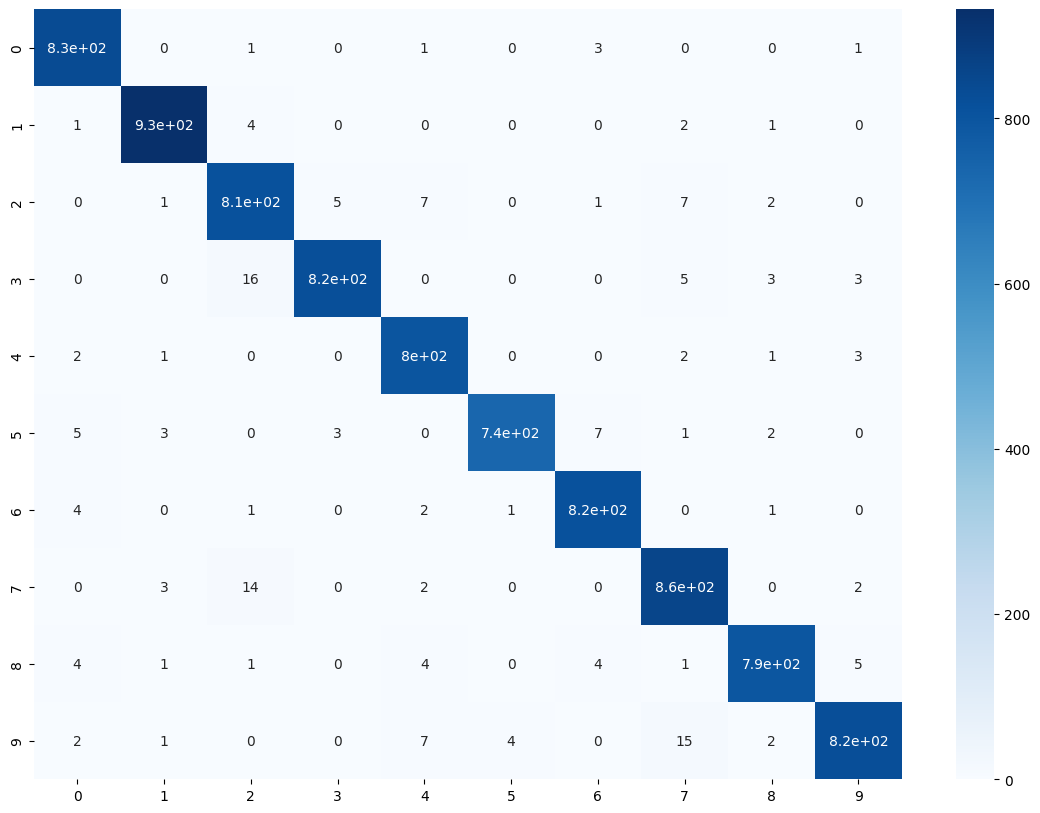

In [56]:
matr = confusion_matrix(labels, preds)

fig, ax = plt.subplots(1,1, figsize=(14,10))
sns.heatmap(matr, annot=True, cmap='Blues', ax=ax)

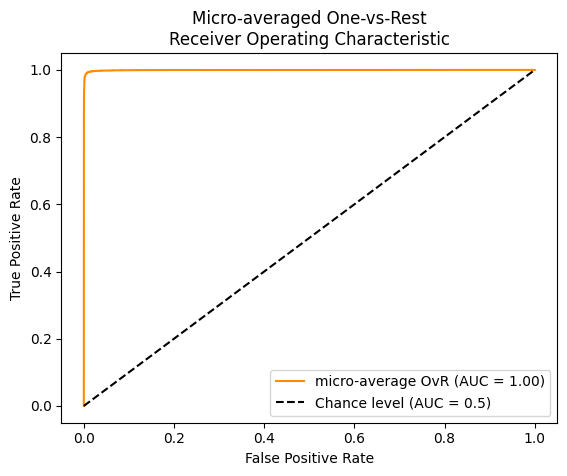

In [57]:

y_train = np.arange(10)
y_test = labels
# print(y_test[0])
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test = np.array(y_onehot_test)
# print(y_onehot_test)
y_score = np.array(y_score.detach().numpy())
display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)